# Prepilot Demo

In [1]:
import os
import sys
import logging
import pandas as pd
import numpy as np
import yaml

sys.path.append(os.path.dirname(os.path.abspath('')))
#from utils.spark import restart_spark
from stratification.params import SplitBuilderParams
from prepilot.params import PrepilotParams
from prepilot.prepilot_experiment_builder import PrepilotExperimentBuilder
from prepilot.prepilot_split_builder import PrepilotSplitBuilder
from auto_ab.abtest import ABTest
from auto_ab.params import ABTestParams

logging.basicConfig(level = logging.INFO)

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('ab_data.csv')

with open("../auto_ab/configs/auto_ab.config.yaml", "r") as stream:
    try:
        ab_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
df["moda_city"] = np.random.randint(1, 5, df.shape[0])
df["moda_city"] = df["moda_city"].astype(str)
df["country"] = np.random.randint(1, 3, df.shape[0])
df["id"] = df.index

df["numerator"] = np.random.randint(1, 5, df.shape[0])
df["denominator"] = np.random.randint(1, 5, df.shape[0])
df["country"] = np.random.randint(1, 3, df.shape[0])

In [4]:
from auto_ab.params import *
data_params = DataParams(**ab_config['data_params'])
simulation_params = SimulationParams(**ab_config['simulation_params'])
hypothesis_params = HypothesisParams(**ab_config['hypothesis_params'])
result_params = ResultParams(**ab_config['result_params'])
splitter_params = SplitterParams(**ab_config['splitter_params'])

ab_params = ABTestParams(data_params,simulation_params,hypothesis_params,result_params,splitter_params)

In [4]:
ab_params = ABTestParams()

In [19]:
ab_params.data_params.numerator = 'numerator'
ab_params.data_params.denominator = 'denominator'

In [7]:
#DATE_FROM = datetime.date(2021, 4, 1)  # CHANGE
#DATE_TO = datetime.date(2021, 4, 15)  # CHANGE
#synthetic_catalog_ids = []  # List[int]
#CAMPAIGN_ID = "CVM-0-0"  # CHANGE - for naming final output files


split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    region_col = "moda_city",
    split_metric_col = "height_now",
    customer_col = "id",
    cols = [],
    cat_cols=[
        #'offer_rk_goal',
        #'offer_rk_campaign'
    ],
    pvalue=0.05,
    n_top_cat=100,
    stat_test="ttest_ind"
)

In [8]:
prepilot_params = PrepilotParams(
    #datestart=datestart,
    #datepostperiod=datepostperiod,
    metrics_names=['height_now'],
    injects=[1.000001 ,1.00001, 1.0001, 1.001],#[1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1,1.15,1.2,1.25],
    min_group_size=10000, 
    max_group_size=50000, 
    step=10000,
    variance_reduction = None,
    use_buckets = False,
    stat_test = ABTest.test_hypothesis_boot_confint,
    iterations_number = 10,
    max_beta_score=0.5,
    min_beta_score=0.02,
)

In [9]:
prepilot = PrepilotExperimentBuilder(df, ab_params,
                                     prepilot_params,
                                     split_builder_params)

In [10]:
%%time
beta,alpha = prepilot.collect()

INFO:stratification.split_builder:Calculate stratas for guest table
INFO:stratification.binning:21015 outliers found
INFO:stratification.split_builder:control: Desired size = 0.05,         resulting size = 9995, diff = 0.05 %
INFO:stratification.split_builder:target: Desired size = 0.052630193942264675,         resulting size = 9997, diff = 0.03 %
INFO:stratification.split_builder:Success!
INFO:stratification.split_builder:control: Desired size = 0.05,         resulting size = 9995, diff = 0.05 %
INFO:stratification.split_builder:target: Desired size = 0.052630193942264675,         resulting size = 9997, diff = 0.03 %
INFO:stratification.split_builder:Success!
INFO:stratification.split_builder:control: Desired size = 0.05,         resulting size = 9995, diff = 0.05 %
INFO:stratification.split_builder:target: Desired size = 0.052630193942264675,         resulting size = 9997, diff = 0.03 %
INFO:stratification.split_builder:Success!
INFO:stratification.split_builder:control: Desired size

CPU times: user 54.6 s, sys: 1.11 s, total: 55.7 s
Wall time: 58.8 s


In [11]:
beta

split_rate         (10000, 10000)  (20000, 20000)  (30000, 30000)  \
metric     MDE                                                      
height_now 1.0001             1.0             1.0             1.0   
           1.0010             0.0             0.0             0.0   

split_rate         (40000, 40000)  (50000, 50000)  
metric     MDE                                     
height_now 1.0001             1.0             1.0  
           1.0010             0.0             0.0

In [12]:
alpha

split_rate,"(10000, 10000)","(20000, 20000)","(30000, 30000)","(40000, 40000)","(50000, 50000)"
metric,,,,,
height_now,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
prepilot_params = PrepilotParams(
    #datestart=datestart,
    #datepostperiod=datepostperiod,
    metrics_names=['height_now'],
    injects=[1.000001 ,1.00001, 1.0001, 1.001],#[1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1,1.15,1.2,1.25],
    min_group_size=10000, 
    max_group_size=50000, 
    step=10000,
    variance_reduction = ABTest.cuped,
    use_buckets = False,
    stat_test = ABTest.test_hypothesis_boot_confint,
    iterations_number = 10,
    max_beta_score=0.5,
    min_beta_score=0.02,
)

In [14]:
prepilot = PrepilotExperimentBuilder(df, ab_params,
                                     prepilot_params,
                                     split_builder_params)

In [15]:
%%time
beta,alpha = prepilot.collect()

INFO:stratification.split_builder:Calculate stratas for guest table
INFO:stratification.binning:21015 outliers found
INFO:stratification.split_builder:control: Desired size = 0.05,         resulting size = 9995, diff = 0.05 %
INFO:stratification.split_builder:target: Desired size = 0.052630193942264675,         resulting size = 9997, diff = 0.03 %
INFO:stratification.split_builder:Success!
INFO:stratification.split_builder:control: Desired size = 0.05,         resulting size = 9995, diff = 0.05 %
INFO:stratification.split_builder:target: Desired size = 0.052630193942264675,         resulting size = 9997, diff = 0.03 %
INFO:stratification.split_builder:Success!
INFO:stratification.split_builder:control: Desired size = 0.05,         resulting size = 9995, diff = 0.05 %
INFO:stratification.split_builder:target: Desired size = 0.052630193942264675,         resulting size = 9997, diff = 0.03 %
INFO:stratification.split_builder:Success!
INFO:stratification.split_builder:control: Desired size

CPU times: user 1min 2s, sys: 1.17 s, total: 1min 4s
Wall time: 1min 4s


In [16]:
beta

split_rate         (10000, 10000)  (20000, 20000)  (30000, 30000)  \
metric     MDE                                                      
height_now 1.0001             0.9             0.9             1.0   
           1.0010             0.0             0.0             0.0   

split_rate         (40000, 40000)  (50000, 50000)  
metric     MDE                                     
height_now 1.0001             0.9             0.9  
           1.0010             0.0             0.0

# Cuped Demo

In [41]:
df = pd.read_csv('ab_data.csv')
ab_test = ABTest(df, ab_params)

In [42]:
ab_test.params.data_params.treatment

array([178.61056532, 180.95401792, 167.59004221, ..., 172.9221543 ,
       172.22400376, 177.60527995])

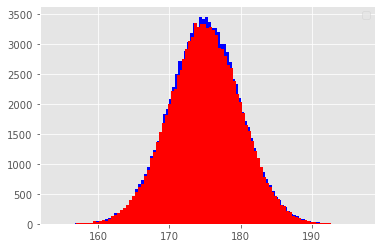

In [43]:
import matplotlib.pyplot as plt

plt.hist(ab_test.params.data_params.treatment, bins = 100, color="blue")
plt.hist(ab_test.params.data_params.control, bins=100, color="red")

plt.style.use('ggplot')
plt.legend(loc='upper right')
plt.show()

In [44]:
ab_test1 = ab_test.cuped()

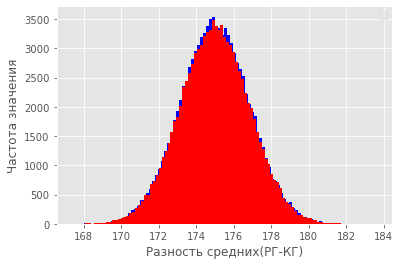

In [45]:
import matplotlib.pyplot as plt

plt.hist(ab_test1.params.data_params.treatment, bins = 100, color="blue")
plt.hist(ab_test1.params.data_params.control, bins=100, color="red")

plt.style.use('ggplot')
plt.xlabel('Разность средних(РГ-КГ)')
plt.ylabel('Частота значения')
plt.legend(loc='upper right')
plt.show()

In [46]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col]=='A', #applied where cond is False
                                        df[ab_test.params.data_params.target]*1.001, 
                                        axis=0,
                                        inplace=True)

ab_test = ABTest(df, ab_params)

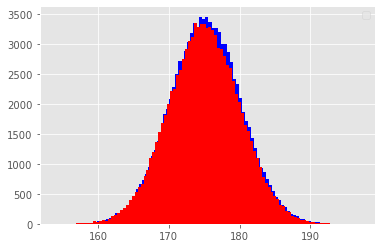

In [47]:
import matplotlib.pyplot as plt

plt.hist(ab_test.params.data_params.treatment, bins = 100, color="blue")
plt.hist(ab_test.params.data_params.control, bins=100, color="red")

plt.style.use('ggplot')
plt.legend(loc='upper right')
plt.show()

In [48]:
ab_test2 = ab_test.cuped()

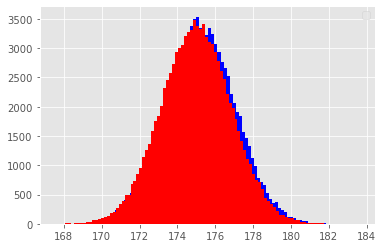

In [49]:
import matplotlib.pyplot as plt

plt.hist(ab_test2.params.data_params.treatment, bins = 100, color="blue")
plt.hist(ab_test2.params.data_params.control, bins=100, color="red")

plt.style.use('ggplot')
plt.legend(loc='upper right')
plt.show()